In [1]:
!pip install streamlit
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.neighbors import NearestNeighbors
from scipy.sparse import csr_matrix

In [3]:
recipes_df = pd.read_csv('C:/1. Jasmine/Mine Docs/Learning/My Projs/Recommendation_foods/data/RAW_recipes.csv')
recipe_data = recipes_df[['id', 'name', 'ingredients', 'minutes', 'tags']]
recipe_data.head()

,id,name,ingredients,minutes,tags
0,137739,arriba baked winter squash mexican style,"['winter squash', 'mexican seasoning', 'mixed ...",55,"['60-minutes-or-less', 'time-to-make', 'course..."
1,31490,a bit different breakfast pizza,"['prepared pizza crust', 'sausage patty', 'egg...",30,"['30-minutes-or-less', 'time-to-make', 'course..."
2,112140,all in the kitchen chili,"['ground beef', 'yellow onions', 'diced tomato...",130,"['time-to-make', 'course', 'preparation', 'mai..."
3,59389,alouette potatoes,"['spreadable cheese with garlic and herbs', 'n...",45,"['60-minutes-or-less', 'time-to-make', 'course..."
4,44061,amish tomato ketchup for canning,"['tomato juice', 'apple cider vinegar', 'sugar...",190,"['weeknight', 'time-to-make', 'course', 'main-..."


In [4]:
user_ratings_cleaned = pd.read_csv("C:/1. Jasmine/Mine Docs/Learning/My Projs/Recommendation_foods/data/RAW_interactions.csv")

#Sample a small fraction of users and recipes for testing
sampled_users = user_ratings_cleaned['user_id'].sample(frac=0.01, random_state=42).unique()
sampled_recipes = user_ratings_cleaned['recipe_id'].sample(frac=0.01, random_state=42).unique()

#Filter the user ratings DataFrame to include only the sampled users and recipes
user_ratings_sampled = user_ratings_cleaned[user_ratings_cleaned['user_id'].isin(sampled_users) & 
                                            user_ratings_cleaned['recipe_id'].isin(sampled_recipes)]

#Reindex user_id and recipe_id to continuous integers
user_ratings_sampled['user_idx'] = user_ratings_sampled['user_id'].astype('category').cat.codes
user_ratings_sampled['recipe_idx'] = user_ratings_sampled['recipe_id'].astype('category').cat.codes

#Check for duplicates
duplicate_entries = user_ratings_sampled[user_ratings_sampled.duplicated(subset=['user_idx', 'recipe_idx'], keep=False)]

#Aggregate duplicate entries by taking the mean rating for each user-recipe pair
user_ratings_aggregated = user_ratings_sampled.groupby(['user_idx', 'recipe_idx']).agg({'rating': 'mean'}).reset_index()

#Keep only the first rating for each user-recipe pair
user_ratings_unique = user_ratings_sampled.drop_duplicates(subset=['user_idx', 'recipe_idx'], keep='first')
user_ratings_unique.head()

C:\Users\jasmine.thant\AppData\Local\Temp\ipykernel_6952\2651016784.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_ratings_sampled['user_idx'] = user_ratings_sampled['user_id'].astype('category').cat.codes
C:\Users\jasmine.thant\AppData\Local\Temp\ipykernel_6952\2651016784.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  user_ratings_sampled['recipe_idx'] = user_ratings_sampled['recipe_id'].astype('category').cat.codes


,user_id,recipe_id,date,rating,review,user_idx,recipe_idx
234,280271,250609,2008-04-05,5,I have to give this a 5 star. I don't care for...,2380,6947
565,2503874,129377,2012-11-16,4,set up beautifully once it was completely cool...,5916,4616
605,4470,64124,2004-05-18,5,This glaze is wonderful! The meat was moist ...,12,2497
606,129958,64124,2004-05-25,4,"A very easy, moist and tender pork loin. I ha...",1223,2497
607,283251,64124,2006-03-20,4,This was fabulous! I used the zest and juice o...,2402,2497


In [6]:
#Fill missing values with 0 - indicating no interaction
user_recipe_matrix = user_ratings_aggregated.pivot(index='user_idx', columns='recipe_idx', values='rating').fillna(0)

#Convert the matrix to a sparse format to save memory
user_recipe_sparse = csr_matrix(user_recipe_matrix.values)

#Fit the NearestNeighbors model using the sparse matrix
model_knn = NearestNeighbors(metric='cosine', algorithm='brute')
model_knn.fit(user_recipe_sparse)

NearestNeighbors(algorithm='brute', metric='cosine')

In [7]:
import re

def filter_recipes_by_ingredients(recipe_data, available_ingredients):
    # Convert available_ingredients to lowercase for case-insensitive comparison
    available_ingredients = set([ing.lower() for ing in available_ingredients])

    # Function to clean the string and convert it to a list of ingredients
    def clean_ingredients(ingredients_str):
        # If the ingredients are already a list, return them as they are
        if isinstance(ingredients_str, list):
            return ingredients_str
         # Otherwise, use regex to remove unwanted characters like brackets and quotes
        ingredients = re.findall(r"'(.*?)'", ingredients_str)
        return ingredients

    # Apply the cleaning function to the 'ingredients' column
    recipe_data['ingredients'] = recipe_data['ingredients'].apply(clean_ingredients)

    def ingredient_check(ingredients):
        # Ensure ingredients is a list and convert to lowercase
        ingredients = set([ing.lower() for ing in ingredients])
        # Check if any of the available ingredients are in the recipe's ingredients
        return bool(ingredients.intersection(available_ingredients))

    # Apply the filtering using the ingredient_check function
    filtered_recipes = recipe_data[recipe_data['ingredients'].apply(ingredient_check)]
    return filtered_recipes

def filter_recipes_by_time(recipe_data, max_cooking_time):
    # Filter recipes based on the maximum cooking time
    filtered_by_time = recipe_data[recipe_data['minutes'] <= max_cooking_time]
    
    return filtered_by_time 

In [8]:
def get_final_recommendations(user_id, model_knn, user_recipe_matrix, recipe_data, available_ingredients, max_cooking_time, n_recommendations):
    # Filter the recipes dataset by available ingredients and cooking time
    filtered_by_ingredients = filter_recipes_by_ingredients(recipe_data, available_ingredients)
    print(f"Filtered by_ingredients count: {len(filtered_by_ingredients)}")
    
    filtered_by_time = filter_recipes_by_time(filtered_by_ingredients, max_cooking_time)
    print(f"Filtered by_time count: {len(filtered_by_time)}")
    
    # Get the recommendations from the collaborative filtering model
    if user_id not in user_recipe_matrix.index:
        raise ValueError(f"User ID {user_id} not found in user_recipe_matrix.")
    user_row = user_recipe_matrix.iloc[user_id].values.reshape(1, -1)
    distances, indices = model_knn.kneighbors(user_row, n_neighbors=n_recommendations + 1)
    recommended_recipe_ids = indices.flatten()[1:]
    recommended_recipe_ids = set(recommended_recipe_ids)
    print(f"Recommended recipes Ids for user Id {user_id} are: {recommended_recipe_ids}")
    
    # Filter the recommendations that are within the available ingredients and time constraints
    final_recommendations = filtered_by_time[filtered_by_time['id'].isin(recommended_recipe_ids)]
    
    return final_recommendations

In [9]:
# Define available ingredients and constraints
available_ingredients = {'sugar','apple cider'}
max_cooking_time = 40
user_id = 561
n_recommendations = 50

final_recommendations = get_final_recommendations(user_id, model_knn, user_recipe_matrix, recipe_data, available_ingredients, max_cooking_time,n_recommendations)

# Display the recommended recipes
print(f"Recommended recipes for user Id {user_id} : {final_recommendations}")

C:\Users\jasmine.thant\AppData\Local\Temp\ipykernel_6952\1034446235.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  recipe_data['ingredients'] = recipe_data['ingredients'].apply(clean_ingredients)


Filtered by_ingredients count: 44870
Filtered by_time count: 21402
Recommended recipes Ids for user Id 561 are: {4359, 2312, 1417, 142, 2320, 2065, 4626, 4242, 5018, 5275, 5922, 2851, 551, 3881, 1197, 6062, 2991, 4528, 46, 306, 4147, 4148, 3895, 2110, 3391, 6470, 2762, 203, 4556, 330, 846, 3280, 6610, 2515, 2645, 2902, 215, 2774, 2649, 2135, 5340, 1375, 108, 117, 3318, 759, 3065, 3452, 4989, 2303}
Recommended recipes for user Id 561 :           id                     name  \
102445  2110            harvard beets   
136884  2762  mississippi mud cake ii   
208229  2645              tame kimchi   

                                              ingredients  minutes  \
102445  [beets, cornstarch, water, sugar, vinegar, but...        0   
136884  [butter, cocoa, sugar, eggs, flour, salt, coco...        0   
208229  [red onion, carrots, napa cabbage, kosher salt...        0   

                                                     tags  
102445  ['15-minutes-or-less', 'time-to-make', 'course.

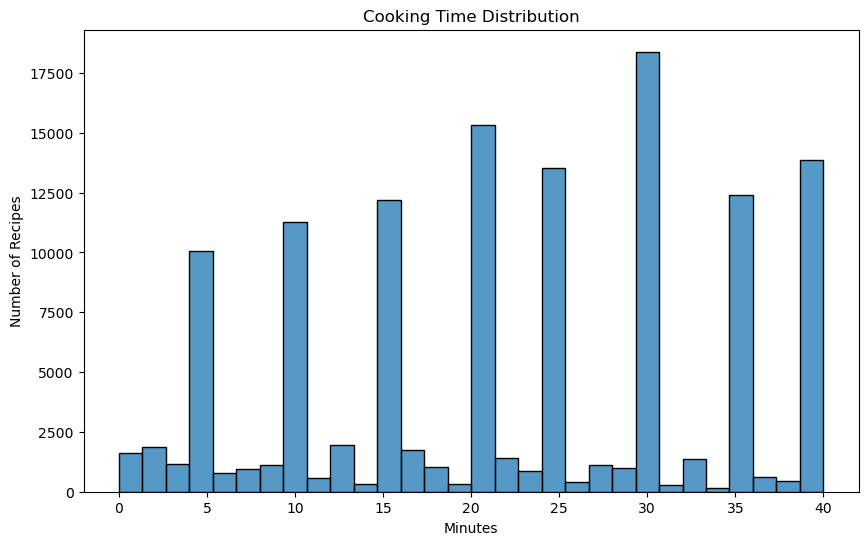

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

capped_recipe_data = recipe_data[recipe_data['minutes'] <= max_cooking_time]

# Visualize cooking time distribution
plt.figure(figsize=(10, 6))
sns.histplot(capped_recipe_data['minutes'], bins=30)
plt.title("Cooking Time Distribution")
plt.xlabel("Minutes")
plt.ylabel("Number of Recipes")
plt.show()
